In [ ]:
import paho.mqtt.client as mqtt
import os
import socket
import ssl
import time
import json
import pandas as pd
from keras.models import load_model, model_from_json
import numpy as np 
import boto3
from datetime import datetime

s3 = boto3.resource('s3')

In [ ]:
import time
from datetime import datetime

df = pd.read_csv("df_mqtt.csv", header=0)

def on_connect(client, userdata, flags, rc):
    print("Connection returned result: " + str(rc) )
    client.subscribe("channel" , 1 )
    
def on_subscribe(mosq, obj, mid, granted_qos):
#     print("Subscribed: " + str(mid) + " " + str(granted_qos))
    pass
    
def on_message(client, userdata, msg):
    global df
    mess = msg.payload
    mess = json.loads(mess.decode('utf8'))
    file_name = len(df)+1
    frame1 = [file_name, (mess["timestamp"]), (mess["value_x"]), (mess["value_y"]), (mess["value_z"]), False]
    columns = ['measurement', 'timestamp', 'value_x', 'value_y', 'value_z', 'anomaly']
    frame = pd.DataFrame( [frame1], columns=columns)
    df = df.append(frame, sort=False)
#     print(df)

mqttc = mqtt.Client("P1")
mqttc.on_connect = on_connect
mqttc.on_message = on_message
mqttc.on_subscribe = on_subscribe

awshost = "a24k1vf8fdqaq9-ats.iot.eu-central-1.amazonaws.com"
awsport = 8883
clientId = "prodline_unity"
thingName = "prodline_unity"
# Root Certificate Path
caPath = "AmazonRootCA1.crt"
# Certificate Path
certPath = "89920469b5-certificate.pem.crt"
# Private Key Certificate Path
keyPath = "89920469b5-private.pem.key"
mqttc.tls_set(caPath, certfile=certPath, keyfile=keyPath, cert_reqs=ssl.CERT_REQUIRED, tls_version=ssl.PROTOCOL_TLSv1_2, ciphers=None)
mqttc.connect(awshost, awsport, keepalive=60)
# mqttc.subscribe("prodline/test")

In [ ]:
mqttc.loop_start()
# time.sleep(10)

with open('model_acc_sensor_popr.json', 'r') as f:
    model = model_from_json(f.read())
model.load_weights('model_acc_sensor_popr.h5')
old_df = 0

while True: 
    if len(df) != old_df:
        
        if len(df) >= 3: #7 CECH
            x = df.tail(3).iloc[:,2].values
            y = df.tail(3).iloc[:,3].values
            z = df.tail(3).iloc[:,4].values
            for i in range(0,3):
                licz=0
                if (220<np.abs(x)[i]<280):
                    licz+=1
                if (220<np.abs(y)[i]<280):
                    licz+=1
                if (220<np.abs(z)[i]<280):
                    licz+=1
            xyz = np.array([[np.mean(abs(x)), np.std(abs(x)), np.mean(abs(y)), np.std(abs(y)), np.mean(abs(z)), np.std(abs(z)), licz]])
            pred = model.predict(xyz)
            print(pred)
            old_df = len(df)
            if pred[0][0] <= 0.5 and pred[0][1] >= 0.5:
                anomaly = True
                df.iloc[-1:,5] = True
                print("anomalia")
            elif pred[0][0] >= 0.5 and pred[0][1] < 0.5:
                anomaly = False

            if df.anomaly.tail(1).values != df.anomaly.tail(2).head(1).values:
                data = str(anomaly)
                path = 'output/' + str(len(df)) + ".json"
                s3.Bucket("intern").put_object(Key=path, Body=data, ACL="public-read-write") 
                print("Saved")           
    else:
        pass


mqttc.loop_stop()
mqttc.disconnect()

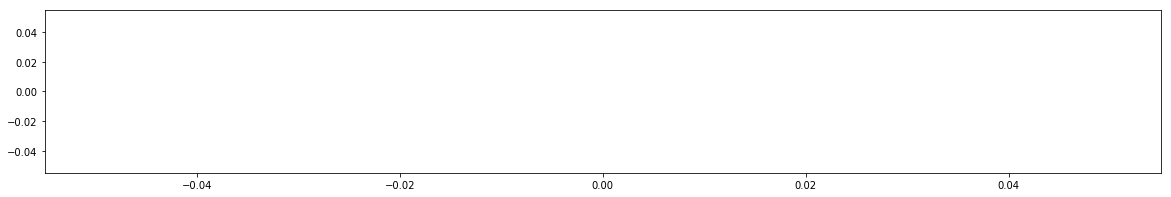

In [5]:
time = []

for i in range(2,len(df)):
    data = df[:i]
    time1 = [(float(data.timestamp.tail(1))-float(data.timestamp.tail(2).head(1)))]
    time.append(time1)
    
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 3))
plt.plot(time)
plt.show()

In [6]:
import pandas as pd
df = pd.read_csv("df_mqtt.csv", header=0)
df

,measurement,timestamp,value_x,value_y,value_z,anomaly
0,0,0.0,0,0,0,False


In [ ]:
import boto3 
import os

def delete_files_s3(x):
    s3 = boto3.resource('s3')
    i=1
    for i in range(0,x):
        path = 'output/' + str(i) + '.json'
        s3.Object('intern', path).delete()
        i+=1
delete_files_s3(1000)
